In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

In [25]:
df_studies = pd.read_csv("../ctg-studies-filtered.csv")
df_studies.head()


,Id,lastUpdateSubmitDate,studyFirstSubmitDate,endDate,overallStatus,phases,sendResult
0,NCT03910439,2021-04-19,2019-04-09,2020-11-04,TERMINATED,PHASE2,True
1,NCT03992170,2019-06-17,2019-06-03,2022-12-31,UNKNOWN,PHASE2,False
2,NCT03891914,2022-03-30,2019-03-25,2022-11-12,UNKNOWN,PHASE3,False
3,NCT04816526,2024-09-30,2021-03-23,2022-11-03,TERMINATED,PHASE2,True
4,NCT03150316,2020-02-20,2017-05-10,2021-09-30,UNKNOWN,PHASE1,False


In [26]:
# Convert to integer (format 'YYYY')
df_studies["startYear"] = df_studies["studyFirstSubmitDate"].str[:4].astype(int)
# if endDate doesn't exist, use lastUpdateSubmitDate
df_studies["endYear"] = df_studies["endDate"].str[:4].fillna(df_studies["lastUpdateSubmitDate"].str[:4]).astype(int)
# create a column with a list of years
df_studies["years"] = df_studies.apply(lambda x: list(range(x["startYear"], x["endYear"] + 1)), axis=1)
# Expand the list of years
df_expanded = df_studies.explode("years").rename(columns={"years": "year"})

In [27]:
df_studies.head()

,Id,lastUpdateSubmitDate,studyFirstSubmitDate,endDate,overallStatus,phases,sendResult,startYear,endYear,years
0,NCT03910439,2021-04-19,2019-04-09,2020-11-04,TERMINATED,PHASE2,True,2019,2020,"[2019, 2020]"
1,NCT03992170,2019-06-17,2019-06-03,2022-12-31,UNKNOWN,PHASE2,False,2019,2022,"[2019, 2020, 2021, 2022]"
2,NCT03891914,2022-03-30,2019-03-25,2022-11-12,UNKNOWN,PHASE3,False,2019,2022,"[2019, 2020, 2021, 2022]"
3,NCT04816526,2024-09-30,2021-03-23,2022-11-03,TERMINATED,PHASE2,True,2021,2022,"[2021, 2022]"
4,NCT03150316,2020-02-20,2017-05-10,2021-09-30,UNKNOWN,PHASE1,False,2017,2021,"[2017, 2018, 2019, 2020, 2021]"


In [28]:
# Define desired statuses. For example, removing undesired ones:
undesired_statuses = {"WITHDRAWN", "SUSPENDED", "UNKNOWN"}
selected_status = [status for status in df_expanded["overallStatus"].unique() 
                   if status not in undesired_statuses]

# Alternatively, define manually:
# selected_status = ["Active", "Completed"]

# Define desired phases (in this example, all available phases)
# selected_phases = list(df_expanded["phases"].unique())
selected_phases = ['PHASE2', 'PHASE3', 'PHASE1', 'PHASE1, PHASE2',
       'EARLY_PHASE1', 'PHASE2, PHASE3']

# Filter studies with or without results:
# Options: "All", "With Results", "Without Results"
selected_results_option = "All"  # Change as needed

# Active years range for the first graph
min_active_year = int(df_expanded["year"].min())
max_active_year = int(df_expanded["year"].max())
active_year_range = (2014, 2024)  # Adjust limits as needed

# Start years range for the second graph
min_start_year = int(df_studies["startYear"].min())
max_start_year = int(df_studies["startYear"].max())
start_year_range = (min_start_year, max_start_year)  # Change if necessary

### --- GRAPH 1: CLINICAL STUDIES BY PHASE (ACTIVE) ---

Increase rate of active studies: 18.01 studies/year


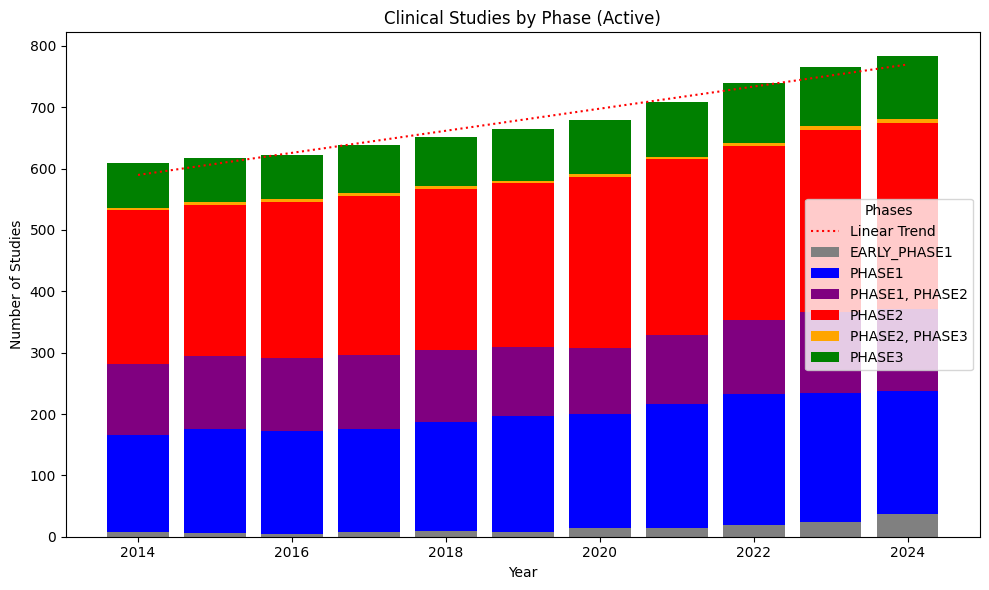

In [30]:
colors = {
    "PHASE1": "blue",
    "PHASE2": "red",
    "PHASE3": "green",
    "PHASE1, PHASE2": "purple",
    "PHASE2, PHASE3": "orange",
    "EARLY_PHASE1": "gray"
}
# Filtering data for the first graph
filtered_active = df_expanded[
    (df_expanded["overallStatus"].isin(selected_status)) &
    (df_expanded["phases"].isin(selected_phases)) &
    (df_expanded["year"] >= active_year_range[0]) &
    (df_expanded["year"] <= active_year_range[1])
]

if selected_results_option == "With Results":
    filtered_active = filtered_active[filtered_active["sendResult"] == True]
elif selected_results_option == "Without Results":
    filtered_active = filtered_active[filtered_active["sendResult"] == False]
# Aggregate study count per year and phase
df_counts = filtered_active.groupby(["year", "phases"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar plot
bottom = np.zeros(len(df_counts.index))
for phase in df_counts.columns:
    color = colors.get(phase, "black")
    ax.bar(df_counts.index, df_counts[phase], bottom=bottom, label=phase, color=color)
    bottom += df_counts[phase].values

# Compute and plot linear trend
total_by_year = df_counts.sum(axis=1)
if len(total_by_year) > 1:
    slope, intercept, _, _, _ = linregress(total_by_year.index, total_by_year.values)
    x_vals = np.array(total_by_year.index)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color="red", linestyle="dotted", label="Linear Trend")
    print(f"Increase rate of active studies: {slope:.2f} studies/year")
else:
    print("Not enough data to calculate active study increase rate.")

ax.set_title("Clinical Studies by Phase (Active)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Studies")
ax.legend(title="Phases")
plt.tight_layout()
plt.show()

### --- GRAPH 2: STUDIES STARTED PER YEAR ---

Increase rate of started studies: 1.65 studies/year


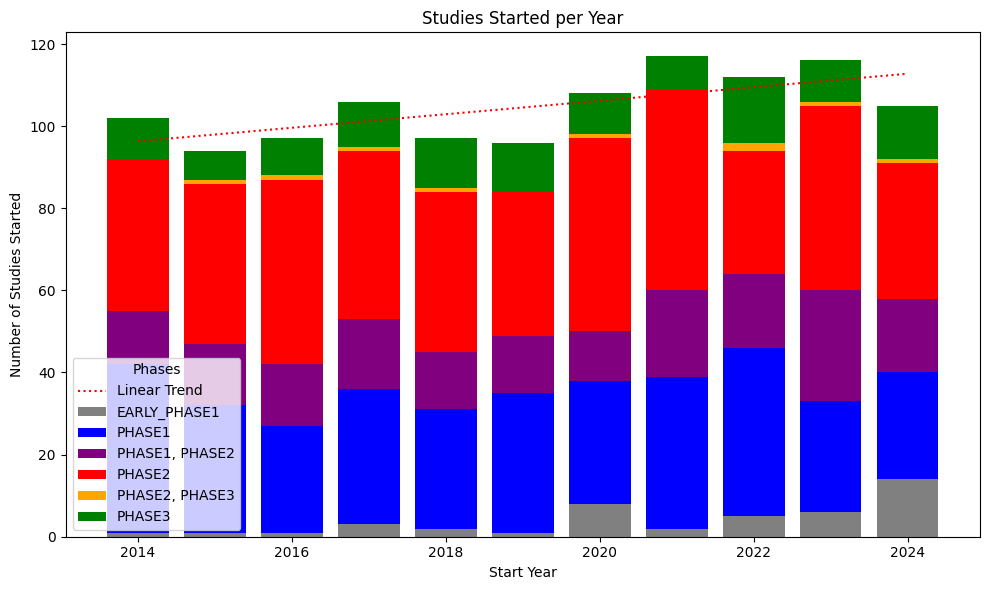

In [31]:
# Filtering data for the second graph (based on start year)
filtered_starts = df_studies[
    (df_studies["overallStatus"].isin(selected_status)) &
    (df_studies["phases"].isin(selected_phases)) &
    (df_studies["startYear"] >= 2014) &
    (df_studies["startYear"] <= start_year_range[1])
]

if selected_results_option == "With Results":
    filtered_starts = filtered_starts[filtered_starts["sendResult"] == True]
elif selected_results_option == "Without Results":
    filtered_starts = filtered_starts[filtered_starts["sendResult"] == False]

# Aggregate study count by start year and phase
df_starts = filtered_starts.groupby(["startYear", "phases"]).size().unstack(fill_value=0)

fig2, ax2 = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(df_starts.index))
for phase in df_starts.columns:
    color = colors.get(phase, "black")
    ax2.bar(df_starts.index, df_starts[phase], bottom=bottom, label=phase, color=color)
    bottom += df_starts[phase].values

# Compute and plot linear trend for started studies
total_starts_by_year = df_starts.sum(axis=1)
if len(total_starts_by_year) > 1:
    slope_start, intercept_start, _, _, _ = linregress(total_starts_by_year.index, total_starts_by_year.values)
    x_vals = np.array(total_starts_by_year.index)
    y_vals = slope_start * x_vals + intercept_start
    ax2.plot(x_vals, y_vals, color="red", linestyle="dotted", label="Linear Trend")
    print(f"Increase rate of started studies: {slope_start:.2f} studies/year")
else:
    print("Not enough data to calculate started study increase rate.")

ax2.set_title("Studies Started per Year")
ax2.set_xlabel("Start Year")
ax2.set_ylabel("Number of Studies Started")
ax2.legend(title="Phases")
plt.tight_layout()
plt.show()